# Vector Space Model


In [314]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer      
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from math import log10, log2, log, exp
import splitter
from num2words import num2words
import contractions
from nltk.corpus import wordnet

# Read corpus from Cranfield

In [315]:
corpus = []
for file_name in range(1400):
    with open(f'Cranfield/{file_name+1}.txt', encoding='UTF-8') as f:
        doc = f.readline()
        corpus.append(doc)
        
print('Number of document in corpus: ', len(corpus))
corpus[:5]

Number of document in corpus:  1400


['experimental investigation of the aerodynamics of a wing in a slipstream . an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem . the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary layer control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory . an empirical evaluation of the destalling effects was made for the specific configuration of the experiment . ',
 "simple shear flow past a flat plate in an incompressible fluid of small viscosity . in t

# Read Author and Bibliography list for each document

Author: Đây là thuộc tính chỉ tác giả của tài liệu. Nếu tài liệu không có thông tin tác giả, giá trị của thuộc tính này sẽ bằng rỗng.

Bibliography: Đây là thuộc tính mô tả các thông tin về tài liệu, bao gồm tên tác giả, tên tài liệu, tên tạp chí hoặc hội nghị, số tập, trang, năm xuất bản.

In [316]:
with open(f'authors_of_document.txt', encoding='UTF-8') as f:
    authors = f.readlines()
authors = [author.strip('\n') for author in authors]

with open(f'biblios_of_document.txt', encoding='UTF-8') as f:
    biblios = f.readlines()
    
authors = [author.strip('\n') for author in authors]
biblios = [biblio.strip('\n') for biblio in biblios]


In [317]:
authors[:5]

['brenckman m ', 'ting yili', 'm  b  glauert', 'yen k t ', 'wasserman b ']

In [318]:
biblios[:5]

['j  ae  scs  25  1958  324 ',
 'department of aeronautical engineering  rensselaer polytechnic institute troy  n y ',
 'department of mathematics  university of manchester  manchester  england',
 'j  ae  scs  22  1955  728 ',
 'j  ae  scs  24  1957  924 ']

Add author and biblios to document

In [319]:
for i in range(len(corpus)):
    corpus[i] += ' ' + authors[i] + ' ' + biblios[i]

# Read query

In [320]:
with open('TEST/query.txt', encoding='UTF-8') as f:
    q = f.readlines()
query = [query.split('\t')[1].strip() for query in q]

print('Number of query: ', len(query))
query[:5]

Number of query:  225


['what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .',
 'what are the structural and aeroelastic problems associated with flight of high speed aircraft .',
 'what problems of heat conduction in composite slabs have been solved so far .',
 'can a criterion be developed to show empirically the validity of flow solutions for chemically reacting gas mixtures based on the simplifying assumption of instantaneous local chemical equilibrium .',
 'what chemical kinetic system is applicable to hypersonic aerodynamic problems .']

# Read relevant documents

In [321]:
relevants = []
for rel_file in range(225):
    with open(f'TEST/RES/{rel_file+1}.txt', encoding='UTF-8') as f:
        rel = f.readlines()
        doc_id = [int(doc_id.split()[1].split('\t')[0]) for doc_id in rel]
        relevants.append(doc_id)
        
print('Number of Relevant document: ', len(relevants))
print(f'Relevant document of query 1: {relevants[0]}')

Number of Relevant document:  225
Relevant document of query 1: [184, 29, 31, 12, 51, 102, 13, 14, 15, 57, 378, 859, 185, 30, 37, 52, 142, 195, 875, 56, 66, 95, 462, 497, 858, 876, 879, 880, 486]


# Preprocessing data

In [322]:
corpus[0]

'experimental investigation of the aerodynamics of a wing in a slipstream . an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem . the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary layer control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory . an empirical evaluation of the destalling effects was made for the specific configuration of the experiment .  brenckman m  j  ae  scs  25  1958  324 '

In [323]:
def Convert_lowercase(doc):
    return doc.lower()

def Contractions(doc):
    return contractions.fix(doc)

def Remove_punctuation(doc):
    punctuation = '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~''' 
    for punc in punctuation:
        if punc in "',.":
            doc = doc.replace(punc, '')    
        else:
            doc = doc.replace(punc, ' ')    
    return doc

def Remove_stopword(doc):
    with open('stopword-en.txt') as f:
        stop_words = f.readlines()   
    stop_words = [word.strip() for word in stop_words]
    #stop_words = stopwords.words('english') #nltk
    new_doc = ''
    for word in word_tokenize(doc):
        if word not in stop_words:
            if (len(word) > 1) or (word.isnumeric()):
                new_doc += word + ' '
    return new_doc

def Standar_number(doc):
    new_doc = ''
    for word in word_tokenize(doc):
        if word.isnumeric():
            number_string = num2words(int(word))
            number_string = number_string.replace('-',' ')
            number_string = number_string.replace(',',' ')
            new_doc += number_string + ' '   
        else: new_doc += word + ' '
    return new_doc

def Stemming(doc):
    new_doc = ''
    for word in word_tokenize(doc):
        #new_doc += PorterStemmer().stem(word) + ' '                         #5396 terms 
        #new_doc += SnowballStemmer(language='english').stem(word) + ' '     #5360 terms 
        new_doc += LancasterStemmer().stem(word) + ' '                      #4797 terms 
        #new_doc += WordNetLemmatizer().lemmatize(word) + ' '                #7157 terms 
    return new_doc


In [324]:
data = []
for doc in corpus:
    doc = Convert_lowercase(doc)
    doc = Remove_punctuation(doc)
    doc = Remove_stopword(doc)
    doc = Standar_number(doc)
    doc = Stemming(doc)
    data.append(doc)
    

In [325]:
data_token = [word_tokenize(data_token) for data_token in data]

In [326]:
print(data_token[0])

['expery', 'investig', 'aerodynam', 'wing', 'slipstream', 'expery', 'study', 'wing', 'propel', 'slipstream', 'determin', 'spanw', 'distribut', 'lift', 'increas', 'slipstream', 'angl', 'attack', 'wing', 'stream', 'slipstream', 'veloc', 'ratio', 'intend', 'evalu', 'bas', 'theoret', 'tre', 'comp', 'span', 'load', 'curv', 'support', 'evid', 'subst', 'lift', 'incr', 'produc', 'slipstream', 'destal', 'bound', 'lay', 'control', 'integr', 'remain', 'lift', 'incr', 'subtract', 'destal', 'lift', 'agr', 'pot', 'flow', 'the', 'empir', 'evalu', 'destal', 'effect', 'spec', 'config', 'expery', 'brenckm', 'scs', 'twenty', 'fiv', 'on', 'thousand', 'nin', 'hundr', 'and', 'fifty', 'eight', 'three', 'hundr', 'and', 'twenty', 'four']


# Indexing

In [327]:
def term_unique(data_token):
    terms = []
    for i in range(len(data_token)):
        terms.extend(data_token[i])
    terms = sorted(list(set(terms)))
    return terms
                
def Vocabulary_and_Posting(data_token, terms):
    terms = terms                                   # Từ khóa
    num_doc = [0 for i in range(len(terms))]        # Số tài liệu
    freq = [0 for i in range(len(terms))]           # Tần số của từ khóa cho tập từ vựng
    doc_id = [[] for i in range(len(terms))]        # Chỉ số tài liệu
    freq_in_docs = [[] for i in range(len(terms))]  # Tần số từ khóa cho DS Posting

    for i in range(len(terms)):
        for j in range(len(data_token)):
            if terms[i] in data_token[j]:
                count_term = data_token[j].count(terms[i])
                if count_term > 0:
                    num_doc[i] += 1
                    freq[i] += count_term
                    doc_id[i].append(j+1)
                    freq_in_docs[i].append(count_term)
    return terms, num_doc, freq, doc_id, freq_in_docs

In [328]:
terms = term_unique(data_token)
len(terms)

4797

In [329]:
terms

['014x10',
 '015x106',
 '0195e',
 '06x10',
 '08a',
 '0degree',
 '0degrees',
 '100degrees',
 '100x10',
 '10degree',
 '10degrees',
 '10g',
 '10th',
 '1103a',
 '11in',
 '12degree',
 '13x10',
 '1400degreek',
 '14in',
 '15000degree',
 '159l',
 '15degree',
 '15x10',
 '16x10',
 '1700f',
 '18000k',
 '180degree',
 '18degree',
 '18in',
 '18x10',
 '1degree',
 '1f',
 '1x10',
 '2000degreek',
 '200degree',
 '20degree',
 '20degreec',
 '20degrees',
 '225x10',
 '23x10',
 '2400degree',
 '24s',
 '25degree',
 '25degrees',
 '2n',
 '2nd',
 '2p',
 '2x10',
 '3000degreek',
 '30degree',
 '30th',
 '32pp',
 '32x10',
 '3300degreer',
 '3600degreek',
 '3800degree',
 '38x10',
 '39x10',
 '3ft',
 '3rd',
 '4000degreek',
 '40degree',
 '446j',
 '45degree',
 '45degrees',
 '49degree',
 '4degree',
 '4degrees',
 '4ft',
 '4th',
 '4x10',
 '500degree',
 '50degree',
 '50degrees',
 '55degrees',
 '57d19a',
 '58l',
 '58w',
 '59a',
 '59l',
 '5d',
 '5section',
 '5th',
 '6000degreek',
 '60degree',
 '60degrees',
 '63a2xx',
 '63a4xx',
 '

In [330]:
terms, num_doc, freq, doc_id, freq_in_docs = Vocabulary_and_Posting(data_token, terms)


In [331]:
pd.DataFrame({'Từ khóa':terms, 'Số tài liệu':num_doc, 'Tần số':freq, 'Chỉ số tài liệu':doc_id, 'Tần số trong mỗi tài liệu':freq_in_docs})

,Từ khóa,Số tài liệu,Tần số,Chỉ số tài liệu,Tần số trong mỗi tài liệu
0,014x10,1,1,[689],[1]
1,015x106,1,1,[993],[1]
2,0195e,1,1,[741],[1]
3,06x10,1,1,[662],[1]
4,08a,1,1,[749],[1]
...,...,...,...,...,...
4792,zlotnick,2,2,"[1332, 1334]","[1, 1]"
4793,zon,13,20,"[14, 126, 167, 218, 243, 455, 828, 960, 1072, ...","[2, 2, 1, 1, 3, 1, 1, 2, 3, 1, 1, 1, 1]"
4794,zoom,1,2,[374],[2]
4795,zuk,2,2,"[886, 890]","[1, 1]"


In [332]:
# Vector tần số của các document 
doc_vec = [[0 for i in range(len(terms))] for _ in range(len(data_token))]

for i in range(len(doc_id)):
    for j in range(len(doc_id[i])):
        doc_vec[doc_id[i][j]-1][i] = freq_in_docs[i][j] 

Bảng thống kê tần số của các từ trong tài liệu

In [333]:
pd.DataFrame(data=doc_vec, columns=terms, index=[f'Doc_{i+1}' for i in range(1400)])

,014x10,015x106,0195e,06x10,08a,0degree,0degrees,100degrees,100x10,10degree,...,zero,zeydel,zhukhovitski,zienkiewicz,zier,zlotnick,zon,zoom,zuk,zurich
Doc_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc_1396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_1397,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Doc_1398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_1399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculate TF-IDF of Document

Calculate IDF, IF, W

In [334]:
#doc_idf = [log2(len(data_token)/n_doc) for n_doc in num_doc]              # Nghịch đảo 
#doc_idf = [log10(len(data_token)/n_doc) for n_doc in num_doc]             # Nghịch đảo
doc_idf = [log(len(data_token)/n_doc) for n_doc in num_doc]               # Nghịch đảo

#doc_idf = [log2(len(data_token)/n_doc) ** 2 for n_doc in num_doc]         # Bình phương
#doc_idf = [log10(len(data_token)/n_doc) ** 2 for n_doc in num_doc]        # Bình phương
#doc_idf = [log(len(data_token)/n_doc) ** 2 for n_doc in num_doc]          # Bình phương

#doc_idf = [log2(len(data_token) - n_doc)/n_doc) for n_doc in num_doc]    # Xác suất
#doc_idf = [log10(len(data_token) - n_doc)/n_doc) for n_doc in num_doc]   # Xác suất
#doc_idf = [log((len(data_token) - n_doc)/n_doc) for n_doc in num_doc]     # Xác suất

#doc_idf = [1/n_doc for n_doc in num_doc]                               # Tần suất

doc_tf = list(doc_vec)
doc_w = list(doc_vec)
for i in range(len(doc_vec)):
    if max(doc_vec[i]) != 0:
        norm = 0
        for j in range(len(doc_vec[i])):
            if doc_vec[i][j] != 0:
                #doc_tf[i][j] = doc_vec[i][j] / max(doc_vec[i])             # Chuẩn max
                #doc_tf[i][j] = 0.5 + 0.5*doc_vec[i][j] / max(doc_vec[i])   # Tăng cường
                #doc_tf[i][j] = log2(doc_vec[i][j]) + 1                     # Logarith_2
                #doc_tf[i][j] = log10(doc_vec[i][j]) + 1                    # Logarith_10
                doc_tf[i][j] = log(doc_vec[i][j]) + 1                       # Logarith_e
                norm += np.square(doc_tf[i][j]*doc_idf[j])
        norm = np.sqrt(norm)
        doc_w[i] = [(doc_tf[i][j] * doc_idf[j])/norm for j in range(len(doc_tf[i]))]

Ma trận trọng số các các từ trong từng tài liệu

In [335]:
pd.DataFrame(data=doc_w, columns=terms, index=[f'Doc_{i+1}' for i in range(1400)])

,014x10,015x106,0195e,06x10,08a,0degree,0degrees,100degrees,100x10,10degree,...,zero,zeydel,zhukhovitski,zienkiewicz,zier,zlotnick,zon,zoom,zuk,zurich
Doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc_1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc_1397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc_1398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doc_1399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Process Query

In [336]:
import time
start = time.time()

In [337]:
def expand_query(text):
    tokens = word_tokenize(text)
    expanded_tokens = []
    for token in tokens:
        if LancasterStemmer().stem(token) in terms:
            expanded_tokens.append(token)
        else:
            synonyms = []
            for synset in wordnet.synsets(token):
                for lemma in synset.lemmas():
                    synonyms.append(lemma.name())
            if synonyms:
                for syn in synonyms:
                    if LancasterStemmer().stem(syn) in terms:
                        expanded_tokens.append(syn)  
                        break
                    
    expanded_text = " ".join(expanded_tokens)
    return expanded_text

In [338]:
query_processed = []
for q in query:
    q = Convert_lowercase(q)
    q = Remove_punctuation(q)
    q = Remove_stopword(q)
    q = Standar_number(q)
    q = expand_query(q)
    q = Stemming(q)
    query_processed.append(q)

In [339]:
query[:5]

['what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .',
 'what are the structural and aeroelastic problems associated with flight of high speed aircraft .',
 'what problems of heat conduction in composite slabs have been solved so far .',
 'can a criterion be developed to show empirically the validity of flow solutions for chemically reacting gas mixtures based on the simplifying assumption of instantaneous local chemical equilibrium .',
 'what chemical kinetic system is applicable to hypersonic aerodynamic problems .']

In [340]:
query_token = [word_tokenize(q) for q in query_processed]
for i in range(5):
    print(query_token[i])

['simil', 'law', 'obey', 'construct', 'aeroelast', 'model', 'heat', 'spee', 'aircraft']
['structural', 'aeroelast', 'flight', 'spee', 'aircraft']
['heat', 'conduc', 'composit', 'slab', 'solv']
['crit', 'develop', 'empir', 'valid', 'flow', 'solv', 'chem', 'react', 'gas', 'mixt', 'bas', 'simpl', 'assum', 'inst', 'loc', 'chem', 'equilibr']
['chem', 'kinet', 'appl', 'hyperson', 'aerodynam']


# Calculate TF-IDF of Query


In [341]:
query_tf = [[0 for i in range(len(terms))] for _ in range(len(query))]
query_idf = list(doc_idf)
query_w = [[0 for i in range(len(terms))] for _ in range(len(query))]

for i in range(len(query_token)):
    norm, check = 0, False
    for j in range(len(query_token[i])):
        if query_token[i][j] in terms:
            index = terms.index(query_token[i][j])
            #query_tf[i][index] = query_tf[i].count(query_tf[i][index]) / num_doc[index]            # Chuẩn max
            #query_tf[i][index] = 0.5 + 0.5*query_tf[i].count(query_tf[i][index]) / num_doc[index]  # Tăng cường
            #query_tf[i][index] = log2(query_token[i].count(query_token[i][j]))+1                   # Logarith_2
            #query_tf[i][index] = log10(query_token[i].count(query_token[i][j]))+1                  # Logarith_10
            query_tf[i][index] = log(query_token[i].count(query_token[i][j]))+1                    # Logarith_e
            norm += np.square(query_tf[i][index]*query_idf[index])
            check = True
    if check:
        norm = np.sqrt(norm)
        query_w[i] = [(query_tf[i][j] * query_idf[j])/norm for j in range(len(query_tf[i]))]


In [342]:
pd.DataFrame(data=query_w, columns=terms, index=[f'Query_{i+1}' for i in range(len(query))])

,014x10,015x106,0195e,06x10,08a,0degree,0degrees,100degrees,100x10,10degree,...,zero,zeydel,zhukhovitski,zienkiewicz,zier,zlotnick,zon,zoom,zuk,zurich
Query_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Query_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Query_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Query_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Query_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Query_221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Query_222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Query_223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Query_224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Cosine Similarity

In [343]:
from sklearn.metrics.pairwise import cosine_similarity
similars = cosine_similarity(query_w, doc_w)   # độ tương đồng cosine của từng query cho toàn bộ document 
doc_retrivals = [np.argsort(similars[i])[::-1]+1 for i in range(len(similars))] # Danh sách các document_id trả về theo độ tương đồng cao xuống thấp
for i in range(len(similars)):
    doc_retrivals[i] = doc_retrivals[i][:np.count_nonzero(similars[i])] # Danh sách các doc_id có liên quan <=> độ tương đồng khác 0

# Calculate MAP Interpolate

In [344]:
def Calculate_MAP_Interpolate(query, doc_retrivals, relevants):
    P_of_querys, R_of_querys = [], []
    Precision, Recall = [], []
    for i in range(len(query)):
        count_rel, P_of_query, R_of_query = 0, [], []
        for j in range(len(doc_retrivals[i])):
            if doc_retrivals[i][j] in relevants[i]:
                count_rel += 1
                P_of_query.append(count_rel / (j+1))
                R_of_query.append(count_rel / len(relevants[i]))                   
            if count_rel == len(relevants[i]):
                break

        P_of_querys.append(P_of_query)
        R_of_querys.append(R_of_query)
        
        if P_of_query:
            Precision.append(P_of_query[-1])
        if R_of_query:
            Recall.append(R_of_query[-1])

    AP = []
    for i in range(len(query)):
        P = []
        for j in range(11):
            r, max_p = j/10, 0
            for k in range(len(R_of_querys[i])):
                if R_of_querys[i][k] >= r and P_of_querys[i][k] > max_p:
                    max_p = P_of_querys[i][k]
            P.append(max_p)
        AP.append(sum(P)/11)
        
    print(f'Precision = {sum(Precision)/len(query)}')
    print(f'Recall = {sum(Recall)/len(query)}')
    print(f'MAP_interpolate = {sum(AP)/len(query)}')
    


In [345]:
Calculate_MAP_Interpolate(query, doc_retrivals, relevants)
# Precision = 0.13544445526813578
# Recall = 0.959348999546768
# MAP_interpolate = 0.4277954009285906

Precision = 0.13544445526813578
Recall = 0.959348999546768
MAP_interpolate = 0.4277954009285906


# Best Match 25

In [346]:
doc_len = [[len(data_token[id-1]) for id in ids] for ids in doc_id]

In [347]:
pd.DataFrame({'Từ khóa':terms, 'Số tài liệu':num_doc, 'Tần số':freq, 'Chỉ số tài liệu':doc_id, 'Tần số trong mỗi tài liệu':freq_in_docs, 'Độ dài tài liệu':doc_len})

,Từ khóa,Số tài liệu,Tần số,Chỉ số tài liệu,Tần số trong mỗi tài liệu,Độ dài tài liệu
0,014x10,1,1,[689],[1],[146]
1,015x106,1,1,[993],[1],[121]
2,0195e,1,1,[741],[1],[63]
3,06x10,1,1,[662],[1],[225]
4,08a,1,1,[749],[1],[81]
...,...,...,...,...,...,...
4792,zlotnick,2,2,"[1332, 1334]","[1, 1]","[84, 92]"
4793,zon,13,20,"[14, 126, 167, 218, 243, 455, 828, 960, 1072, ...","[2, 2, 1, 1, 3, 1, 1, 2, 3, 1, 1, 1, 1]","[195, 83, 71, 134, 54, 112, 96, 74, 195, 71, 1..."
4794,zoom,1,2,[374],[2],[72]
4795,zuk,2,2,"[886, 890]","[1, 1]","[49, 61]"


In [348]:
#idf = [log2(1+(len(data_token) + 0.5)/(n_doc + 0.5)) for n_doc in num_doc]               # Nghịch đảo
#idf = [log10(1+(len(data_token) + 0.5)/(n_doc + 0.5)) for n_doc in num_doc]               # Nghịch đảo
#idf = [log(1+(len(data_token) + 0.5)/(n_doc + 0.5)) for n_doc in num_doc]               # Nghịch đảo

#idf = [log2(1+(len(data_token) + 0.5)/(n_doc + 0.5)) ** 2 for n_doc in num_doc]          # Bình phương
#idf = [log10(1+(len(data_token) + 0.5)/(n_doc + 0.5)) ** 2 for n_doc in num_doc]          # Bình phương
#idf = [log(1+(len(data_token) + 0.5)/(n_doc + 0.5)) ** 2 for n_doc in num_doc]          # Bình phương

#idf = [log2(1+(len(data_token) - n_doc + 0.5)/(n_doc + 0.5)) for n_doc in num_doc]     # Xác suất
#idf = [log10(1+(len(data_token) - n_doc + 0.5)/(n_doc + 0.5)) for n_doc in num_doc]     # Xác suất
idf = [log(1+(len(data_token) - n_doc + 0.5)/(n_doc + 0.5)) for n_doc in num_doc]     # Xác suất

#idf = [1/n_doc for n_doc in num_doc]                               # Tần suất

In [349]:
scores = [[0 for i in range(1400)] for _ in range(len(query))]
k1, b = 2.5, 0.87   # 
doc_len_avg = sum([len(x) for x in data_token]) / len(data_token)

for i in range(len(query_token)):
    for j in range(len(query_token[i])):
        if query_token[i][j] in terms:
            index = terms.index(query_token[i][j])
            for k in range(len(doc_id[index])):
                id = doc_id[index][k]-1
                scores[i][id] += idf[index] * ((freq_in_docs[index][k] * (k1+1)) / (freq_in_docs[index][k] + k1*(1-b+b*doc_len[index][k]/doc_len_avg)))


In [350]:
doc_retrivals = [np.argsort(scores[i])[::-1]+1 for i in range(len(scores))] # Danh sách các document_id trả về theo độ tương đồng cao xuống thấp
for i in range(len(scores)):
    doc_retrivals[i] = doc_retrivals[i][:np.count_nonzero(scores[i])]   # Danh sách các doc_id có liên quan <=> độ tương đồng khác 0
Calculate_MAP_Interpolate(query, doc_retrivals, relevants)
# Precision = 0.1473004855187541
# Recall = 0.959348999546768
# MAP_interpolate = 0.44876609488648295

Precision = 0.1473004855187541
Recall = 0.959348999546768
MAP_interpolate = 0.44876609488648295


# BM25 - CTF - Improving

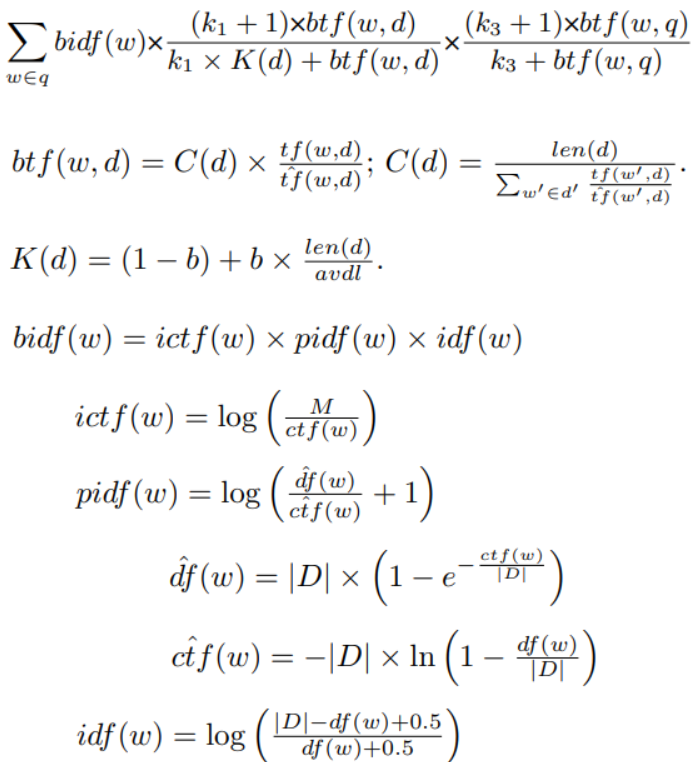

In [351]:
# bidf
total_term_corpus = sum([len(x) for x in data_token])
bidf = []
for i in range(len(terms)):
    ictf = log(total_term_corpus / freq[i])
    pidf = log(-(1 - exp(-freq[i] / len(data_token))) / log(
            1 - num_doc[i] / len(data_token)) + 1)
    #idf = log2(1+(len(data_token) + 0.5)/(num_doc[i] + 0.5))            # Nghịch đảo
    #idf = log10(1+(len(data_token) + 0.5)/(num_doc[i] + 0.5))            # Nghịch đảo
    idf = log(1+(len(data_token) + 0.5)/(num_doc[i] + 0.5))            # Nghịch đảo

    #idf = log2(1+(len(data_token) + 0.5)/(num_doc[i] + 0.5)) ** 2         # Bình phương
    #idf = log10(1+(len(data_token) + 0.5)/(num_doc[i] + 0.5)) ** 2         # Bình phương
    #idf = log(1+(len(data_token) + 0.5)/(num_doc[i] + 0.5)) ** 2         # Bình phương

    #idf = log2(1+(len(data_token) - num_doc[i] + 0.5)/(num_doc[i] + 0.5))     # Xác suất
    #idf = log10(1+(len(data_token) - num_doc[i] + 0.5)/(num_doc[i] + 0.5))     # Xác suất   
    #idf = log(1+(len(data_token) - num_doc[i] + 0.5)/(num_doc[i] + 0.5))     # Xác suất

    #idf = 1/num_doc[i]                                                    # Tần suất
    bidf.append(ictf * pidf * idf)
    
scores = [[0 for i in range(1400)] for _ in range(len(query))]
doc_term_unique = [[idx for idx, value in enumerate(doc_vec[i]) if value != 0] for i in range(len(doc_vec))]
sum_ctf = [sum(freq[idx] for idx in doc_term_unique[id]) for id in range(len(doc_vec))]
sum_ratio = []
for i in range(len(doc_vec)):
    temp = 0
    for j in doc_term_unique[i]:
        tf_ = 1 + (freq[j] / sum_ctf[i]) * (len(data_token[i]) - len(doc_term_unique[i]))
        temp += doc_vec[i][j] / tf_
    sum_ratio.append(temp)

In [352]:
k1, b = 1.7, 0.67
scores = [[0 for i in range(1400)] for _ in range(len(query))]
for i in range(len(query_token)):
    for j in range(len(query_token[i])):
        if query_token[i][j] in terms:
            index = terms.index(query_token[i][j])
            for k in doc_id[index]:
                id = k-1
                C = len(data_token[id]) / sum_ratio[id]
                tf_es = 1 + (freq[index] / sum_ctf[id]) * (len(data_token[id]) - len(doc_term_unique[id]))
                btf = C * (doc_vec[id][index] / tf_es)
                K = k1 * ((1 - b) + b * (len(data_token[id]) / doc_len_avg))
                scores[i][id] += bidf[index] * (btf*(k1+1)/(k1*K+btf)) 


In [353]:
doc_retrivals = [np.argsort(scores[i])[::-1]+1 for i in range(len(scores))] # Danh sách các document_id trả về theo độ tương đồng cao xuống thấp
for i in range(len(scores)):
    doc_retrivals[i] = doc_retrivals[i][:np.count_nonzero(scores[i])]   # Danh sách các doc_id có liên quan <=> độ tương đồng khác 0
Calculate_MAP_Interpolate(query, doc_retrivals, relevants)
# Precision = 0.14887090650335355
# Recall = 0.959348999546768
# MAP_interpolate = 0.4535937190995285

Precision = 0.14887090650335355
Recall = 0.959348999546768
MAP_interpolate = 0.4535937190995285
